[*********************100%%**********************]  4 of 4 completed


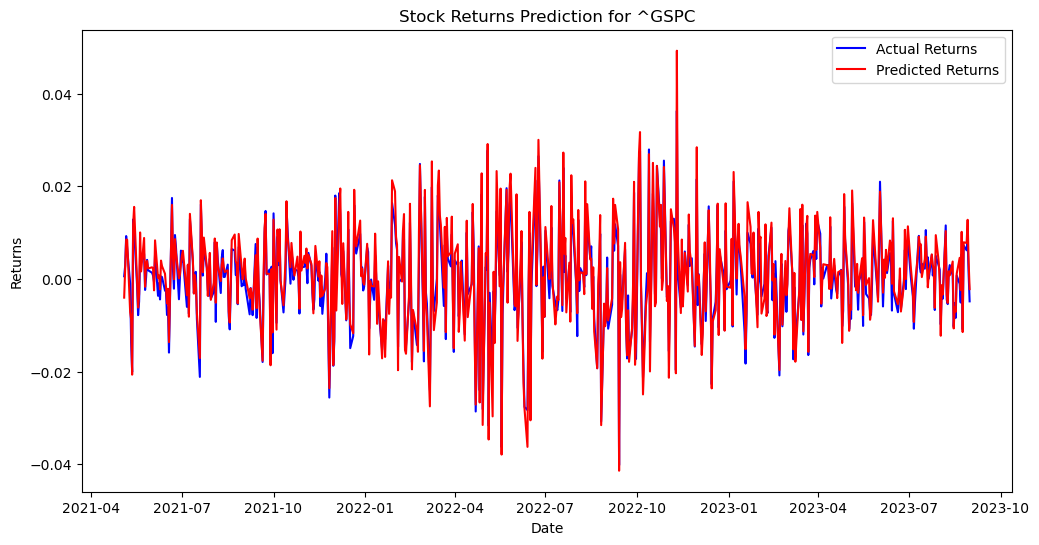

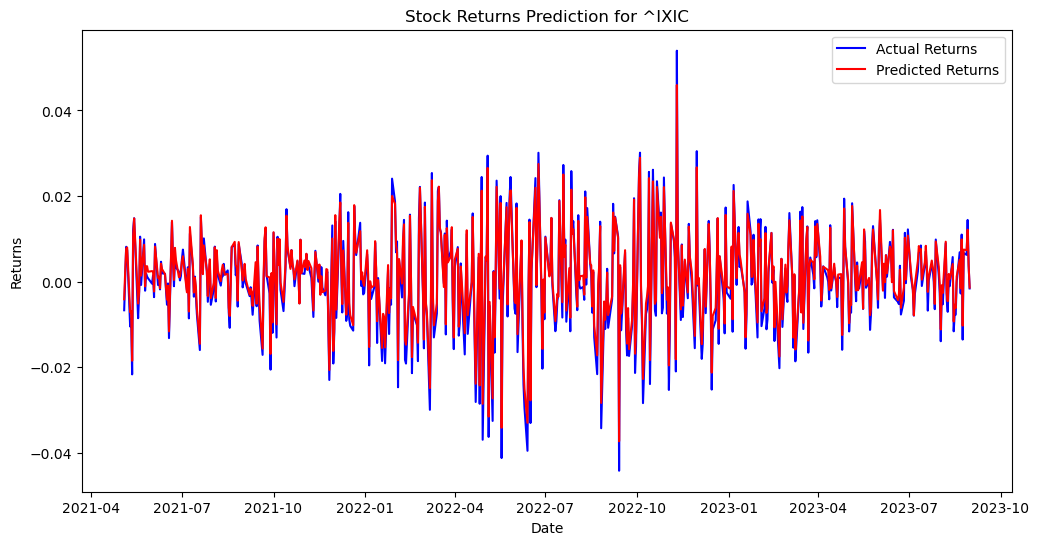

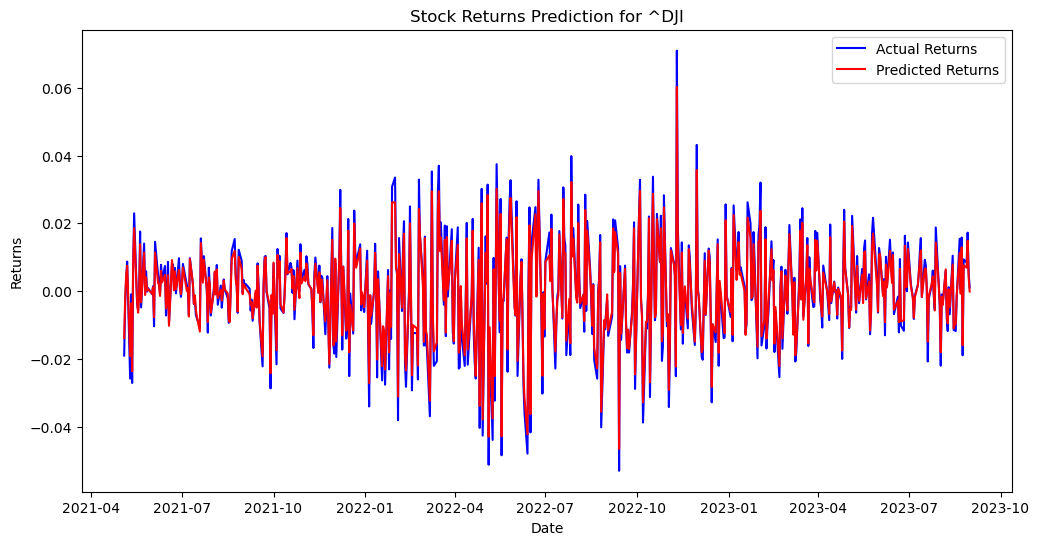

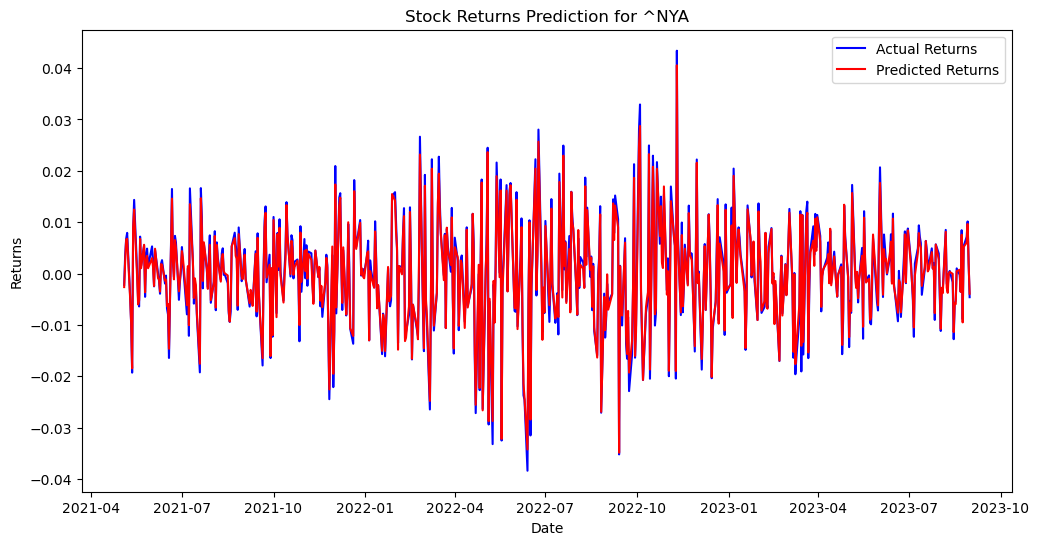

   Stock       MSE       R^2
0  ^GSPC  0.000009  0.913274
1  ^IXIC  0.000005  0.966130
2   ^DJI  0.000008  0.968337
3   ^NYA  0.000002  0.984142
               ^GSPC     ^IXIC      ^DJI      ^NYA
Date                                              
2021-05-04 -0.004035 -0.004139 -0.013838 -0.002640
2021-05-05  0.002468  0.002238 -0.002185  0.002475
2021-05-06  0.008510  0.007701  0.004661  0.006627
2021-05-07  0.008460  0.007975  0.007501  0.006755
2021-05-10 -0.007160 -0.007162 -0.019171 -0.004883
...              ...       ...       ...       ...
2023-08-25  0.007911  0.007481  0.007621  0.005181
2023-08-28  0.007769  0.007357  0.006943  0.006012
2023-08-29  0.012766  0.012132  0.014895  0.009650
2023-08-30  0.003617  0.003738  0.004294  0.001849
2023-08-31 -0.002194 -0.001397 -0.000105 -0.003927

[587 rows x 4 columns]
   Stock       MSE       R^2
0  ^GSPC  0.000009  0.913274
1  ^IXIC  0.000005  0.966130
2   ^DJI  0.000008  0.968337
3   ^NYA  0.000002  0.984142
4  ^GSPC  0.000009  0.9

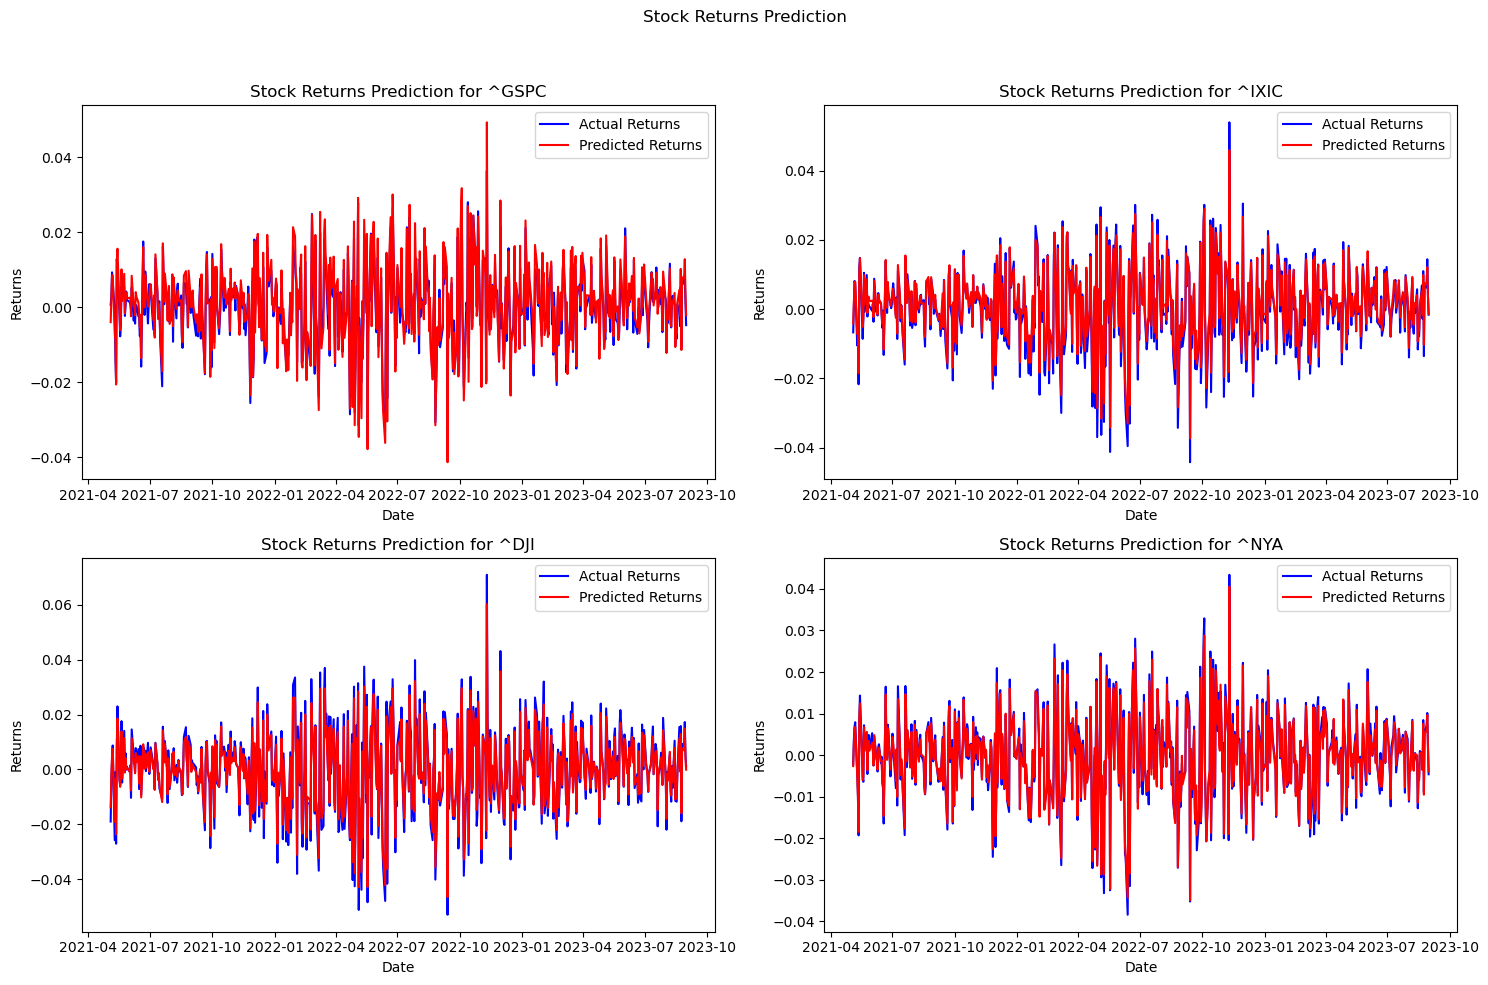

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



startDateStr = '2012-01-01'
endDateStr = '2023-09-01'
instrumentIds = ["^GSPC", "^IXIC", "^DJI", "^NYA"]

data = yf.download(instrumentIds, start=startDateStr, end=endDateStr)['Adj Close']
data = data.fillna(method='ffill')  # Forward fill missing values
return_df = np.log(data / data.shift(1)).dropna()

# 现在可以继续使用 return_df 进行分析和建模



# Feature Engineering: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(return_df)

# Feature Engineering: Perform PCA for dimensionality reduction
pca = PCA(n_components=3)  # Assume selecting 3 principal components
principal_components = pca.fit_transform(scaled_data)

# Split the data into training and testing sets
train_size = int(0.8 * len(return_df))
X_train = principal_components[:train_size]
X_test = principal_components[train_size:]

# Create empty lists to store the results
stocks = []
mse_list = []
r2_list = []
predictions = {}  # Dictionary to store predictions

for i in range(len(instrumentIds)):
    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Calculate MSE and R^2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    r2_list.append(r2)
    
    # Store predictions in the dictionary
    predictions[instrumentIds[i]] = y_pred

    # Visualize the prediction results (optional)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual Returns', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Returns', color='red')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(f'Stock Returns Prediction for {instrumentIds[i]}')
    plt.legend()
    plt.show()

# Create a DataFrame with results
results_df = pd.DataFrame({'Stock': stocks, 'MSE': mse_list, 'R^2': r2_list})

# Print the DataFrame with results
print(results_df)

# Print predictions in DataFrame format
predictions_df = pd.DataFrame(predictions, index=y_test.index)
print(predictions_df)

# Create a single figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stock Returns Prediction')

for i in range(len(instrumentIds)):
    row = i // 2
    col = i % 2

    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Calculate MSE and R^2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    r2_list.append(r2)
    
    # Store predictions in the dictionary
    predictions[instrumentIds[i]] = y_pred

    # Visualize the prediction results
    axes[row, col].plot(y_test.index, y_test.values, label='Actual Returns', color='blue')
    axes[row, col].plot(y_test.index, y_pred, label='Predicted Returns', color='red')
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Returns')
    axes[row, col].set_title(f'Stock Returns Prediction for {instrumentIds[i]}')
    axes[row, col].legend()

# Adjust layout for subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a DataFrame with results
results_df = pd.DataFrame({'Stock': stocks, 'MSE': mse_list, 'R^2': r2_list})

# Print the DataFrame with results
print(results_df)

# Print predictions in DataFrame format
predictions_df = pd.DataFrame(predictions, index=y_test.index)
print(predictions_df)

# Show the combined plot
plt.show()


In [3]:
predictions_df

,^GSPC,^IXIC,^DJI,^NYA
Date,,,,
2021-05-04,-0.004035,-0.004139,-0.013838,-0.002640
2021-05-05,0.002468,0.002238,-0.002185,0.002475
2021-05-06,0.008510,0.007701,0.004661,0.006627
2021-05-07,0.008460,0.007975,0.007501,0.006755
2021-05-10,-0.007160,-0.007162,-0.019171,-0.004883
...,...,...,...,...
2023-08-25,0.007911,0.007481,0.007621,0.005181
2023-08-28,0.007769,0.007357,0.006943,0.006012
2023-08-29,0.012766,0.012132,0.014895,0.009650


In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Create empty lists to store the results
stocks = []
mse_list = []
mae_list = []  # Add MAE list
rmse_list = []  # Add RMSE list
r2_list = []

# ...

for i in range(len(instrumentIds)):
    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Calculate MSE, MAE, RMSE, and R^2
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)  # Calculate MAE
    rmse = np.sqrt(mse)  # Calculate RMSE
    r2 = r2_score(y_test, y_pred)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    mae_list.append(mae)  # Append MAE
    rmse_list.append(rmse)  # Append RMSE
    r2_list.append(r2)

    # ...

# Create a DataFrame with results including MAE, RMSE, and R-squared
results_df = pd.DataFrame({'Stock': stocks, 'MSE': mse_list, 'MAE': mae_list, 'RMSE': rmse_list, 'R^2': r2_list})

# Print the DataFrame with results
print(results_df)

# ...


   Stock       MSE       MAE      RMSE       R^2
0  ^GSPC  0.000009  0.002323  0.002944  0.913274
1  ^IXIC  0.000005  0.001693  0.002158  0.966130
2   ^DJI  0.000008  0.002133  0.002758  0.968337
3   ^NYA  0.000002  0.001029  0.001313  0.984142


Best hyperparameters for ^GSPC:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


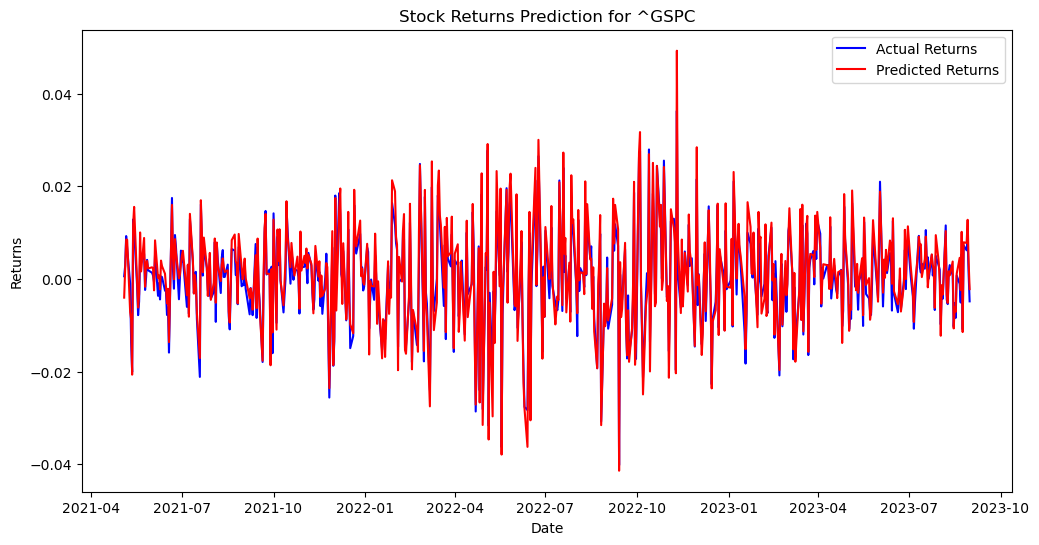

Best hyperparameters for ^IXIC:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


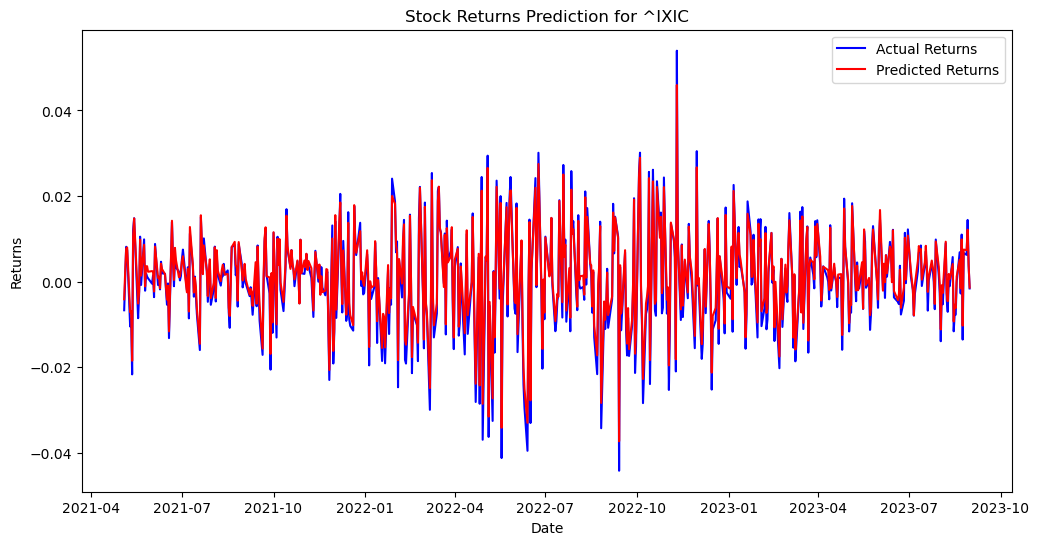

Best hyperparameters for ^DJI:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


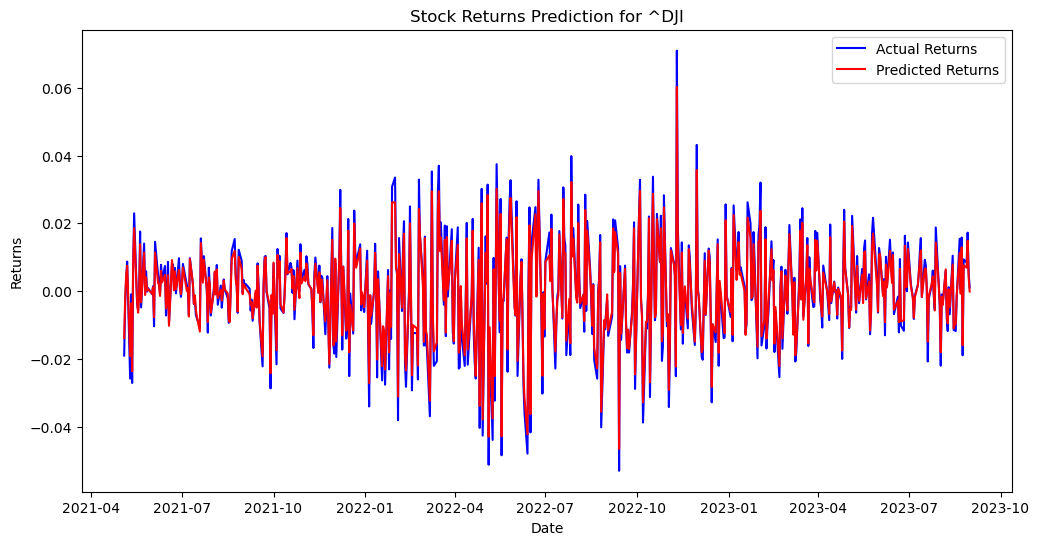

Best hyperparameters for ^NYA:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


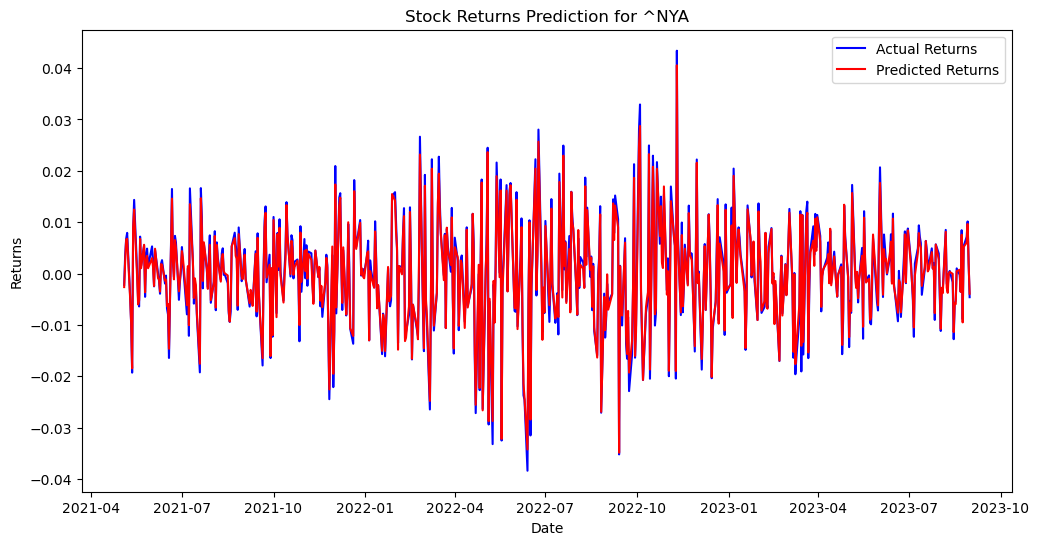

In [7]:
# ...

for i in range(len(instrumentIds)):
    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Print the best hyperparameters
    print(f"Best hyperparameters for {instrumentIds[i]}:")
    print(best_svr.get_params())

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Calculate MSE and R^2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    r2_list.append(r2)
    
    # Store predictions in the dictionary
    predictions[instrumentIds[i]] = y_pred

    # Visualize the prediction results (optional)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual Returns', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Returns', color='red')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(f'Stock Returns Prediction for {instrumentIds[i]}')
    plt.legend()
    plt.show()

# ...


Best hyperparameters for ^GSPC:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


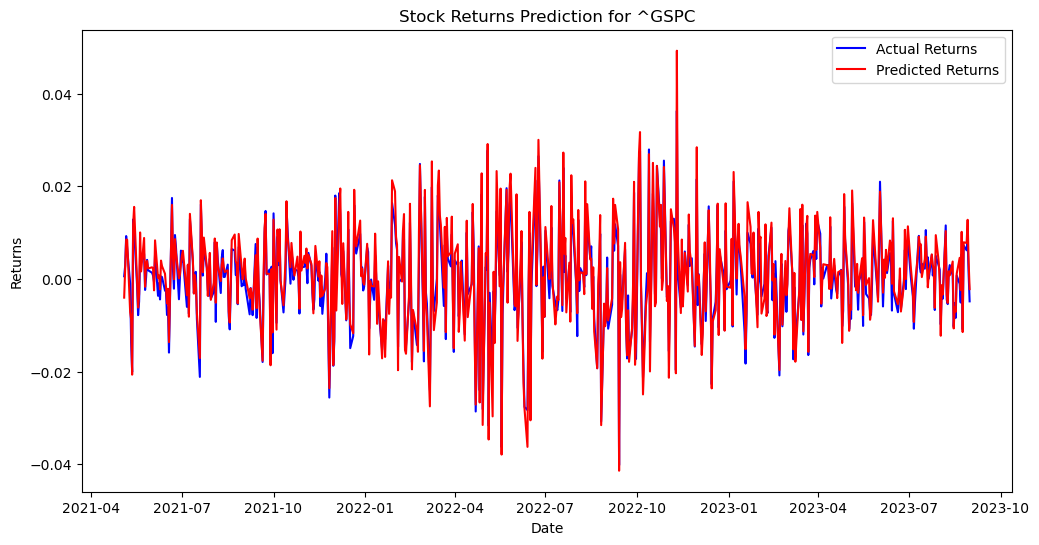

Best hyperparameters for ^IXIC:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


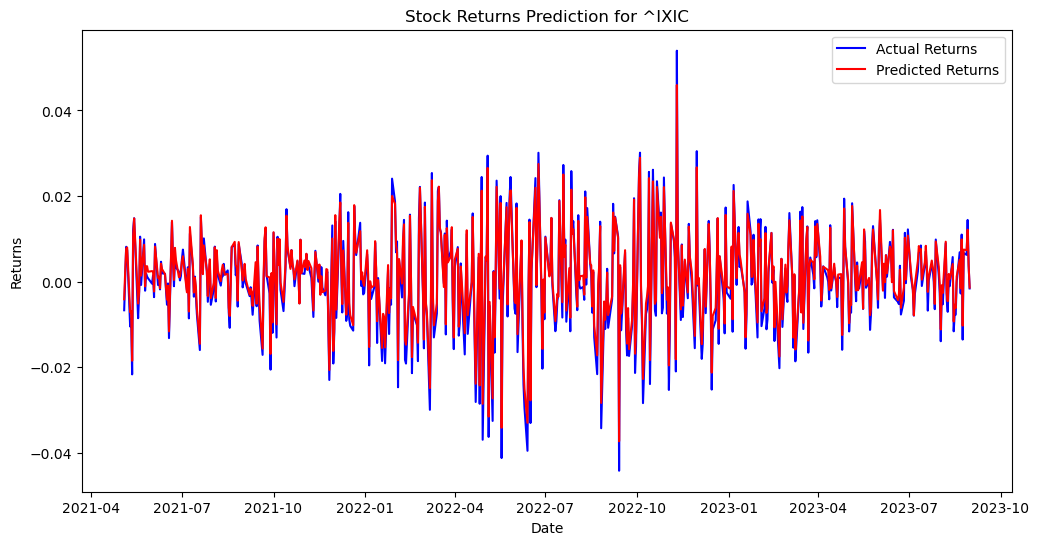

Best hyperparameters for ^DJI:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


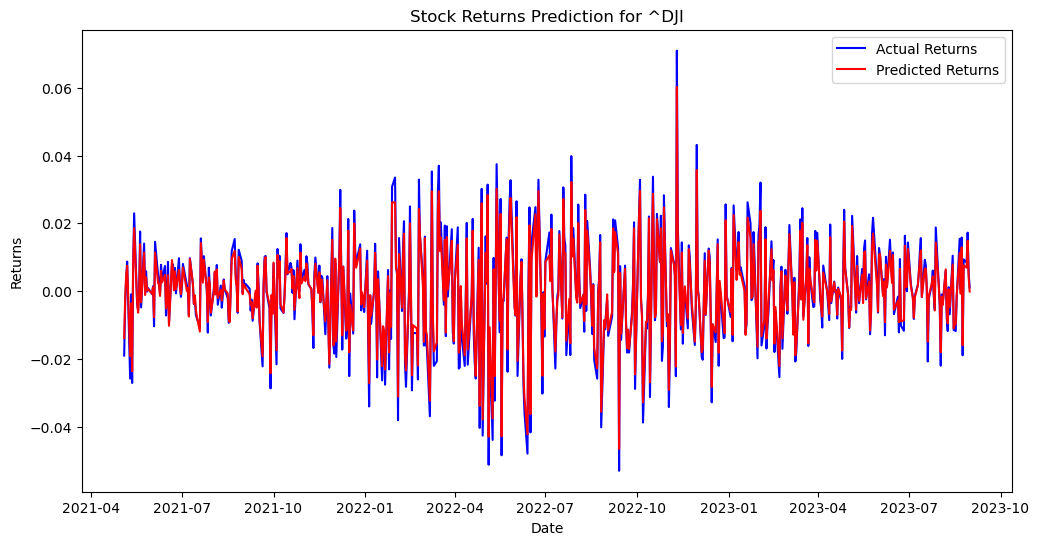

Best hyperparameters for ^NYA:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


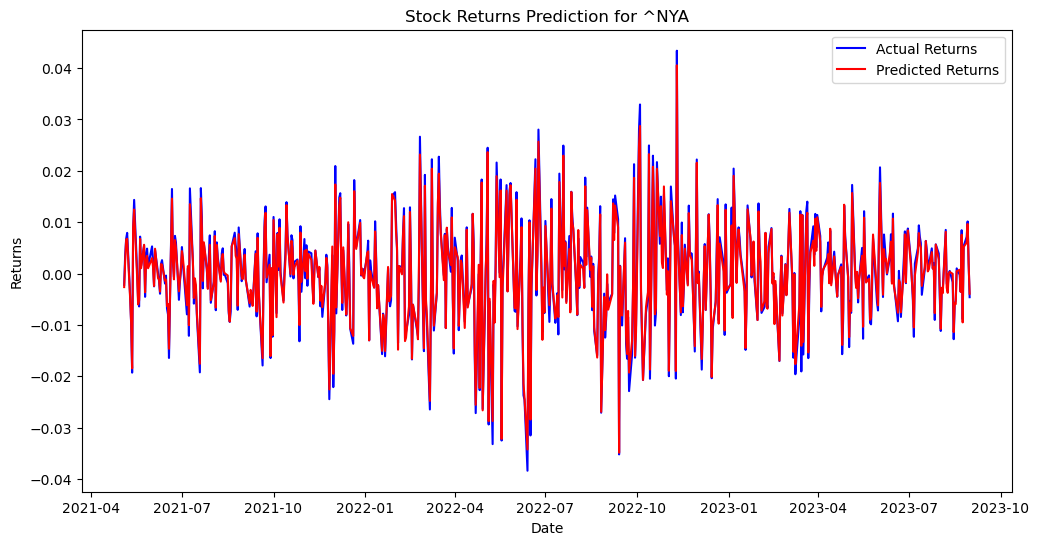

       Stock       MSE       R^2  Best C  Best epsilon  Best kernel
0      ^GSPC  0.000009  0.913274     NaN           NaN          NaN
1      ^IXIC  0.000005  0.966130     NaN           NaN          NaN
2       ^DJI  0.000008  0.968337     NaN           NaN          NaN
3       ^NYA  0.000002  0.984142     NaN           NaN          NaN
4      ^GSPC  0.000009  0.913274     NaN           NaN          NaN
5      ^IXIC  0.000005  0.966130     NaN           NaN          NaN
6       ^DJI  0.000008  0.968337     NaN           NaN          NaN
7       ^NYA  0.000002  0.984142     NaN           NaN          NaN
8      ^GSPC  0.000009  0.913274     NaN           NaN          NaN
9      ^IXIC  0.000005  0.966130     NaN           NaN          NaN
10      ^DJI  0.000008  0.968337     NaN           NaN          NaN
11      ^NYA  0.000002  0.984142     NaN           NaN          NaN
^GSPC    NaN       NaN       NaN     NaN           NaN          NaN
^IXIC    NaN       NaN       NaN     NaN        

Best hyperparameters for ^GSPC:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best hyperparameters for ^IXIC:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best hyperparameters for ^DJI:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best hyperparameters for ^NYA:
{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best Parameters for Each Stock:
       Best C  Best epsilon  Best kernel
^GSPC     NaN           NaN          NaN
^IXIC     NaN           NaN          NaN
^DJ

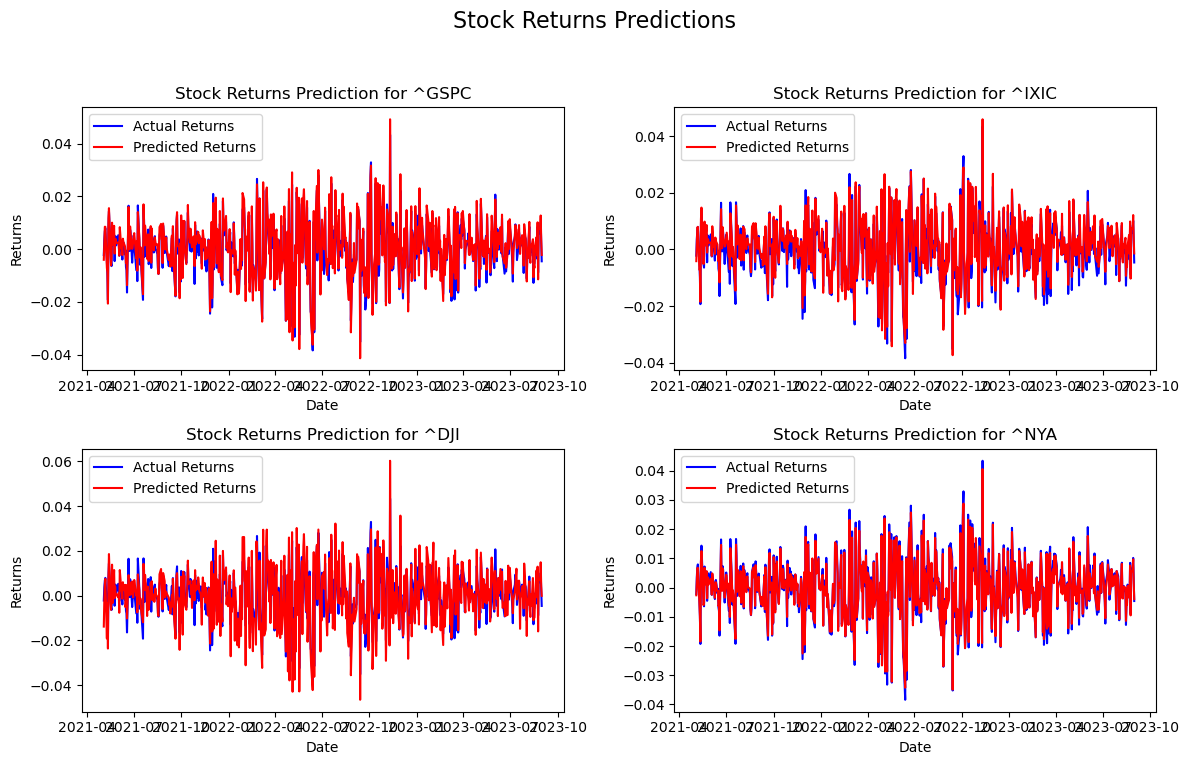

In [10]:
# ...

best_params_list = []  # Create an empty list to store best parameters for each stock
predictions_list = []  # Create an empty list to store predictions for each stock

for i in range(len(instrumentIds)):
    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Print the best hyperparameters
    print(f"Best hyperparameters for {instrumentIds[i]}:")
    print(best_svr.get_params())

    # Append best parameters to the list
    best_params_list.append(best_svr.get_params())

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    r2_list.append(r2)

    # Store predictions in the list
    predictions_list.append(y_pred)

# Create a DataFrame with best parameters
best_params_df = pd.DataFrame(best_params_list, index=instrumentIds, columns=['Best C', 'Best epsilon', 'Best kernel'])

# Create a DataFrame with predictions
predictions_df = pd.DataFrame(predictions_list, index=instrumentIds, columns=y_test.index)

# Create subplots for visualizations
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Stock Returns Predictions', fontsize=16)

for i in range(len(instrumentIds)):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    ax.plot(y_test.index, y_test.values, label='Actual Returns', color='blue')
    ax.plot(y_test.index, predictions_df.iloc[i], label='Predicted Returns', color='red')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.set_title(f'Stock Returns Prediction for {instrumentIds[i]}')
    ax.legend()

# Adjust layout for subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Print the DataFrame with best parameters
print("Best Parameters for Each Stock:")
print(best_params_df)

# Print predictions in DataFrame format
print("Predictions for Each Stock:")
print(predictions_df)

# Show the plots
plt.show()


In [9]:
# ...

for i in range(len(instrumentIds)):
    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Print SVM model parameters
    print(f"=========================== {instrumentIds[i]} ===========================")
    print("SVM Model Parameters:")
    print(best_svr)

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Calculate MSE, MAE, RMSE, and R^2
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)  # Calculate MAE
    rmse = np.sqrt(mse)  # Calculate RMSE
    r2 = r2_score(y_test, y_pred)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    mae_list.append(mae)  # Append MAE
    rmse_list.append(rmse)  # Append RMSE
    r2_list.append(r2)

    # ...

# ...


=========================== ^GSPC ===========================
SVM Model Parameters:
SVR(C=0.1, epsilon=0.01, kernel='linear')
=========================== ^IXIC ===========================
SVM Model Parameters:
SVR(C=0.1, epsilon=0.01, kernel='linear')
=========================== ^DJI ===========================
SVM Model Parameters:
SVR(C=0.1, epsilon=0.01, kernel='linear')
=========================== ^NYA ===========================
SVM Model Parameters:
SVR(C=0.1, epsilon=0.01, kernel='linear')


    Stock       MSE       R^2
0   ^GSPC  0.000009  0.913274
1   ^IXIC  0.000005  0.966130
2    ^DJI  0.000008  0.968337
3    ^NYA  0.000002  0.984142
4   ^GSPC  0.000009  0.913274
5   ^IXIC  0.000005  0.966130
6    ^DJI  0.000008  0.968337
7    ^NYA  0.000002  0.984142
8   ^GSPC  0.000009  0.913274
9   ^IXIC  0.000005  0.966130
10   ^DJI  0.000008  0.968337
11   ^NYA  0.000002  0.984142
               ^GSPC     ^IXIC      ^DJI      ^NYA
Date                                              
2021-05-04 -0.004035 -0.004139 -0.013838 -0.002640
2021-05-05  0.002468  0.002238 -0.002185  0.002475
2021-05-06  0.008510  0.007701  0.004661  0.006627
2021-05-07  0.008460  0.007975  0.007501  0.006755
2021-05-10 -0.007160 -0.007162 -0.019171 -0.004883
...              ...       ...       ...       ...
2023-08-25  0.007911  0.007481  0.007621  0.005181
2023-08-28  0.007769  0.007357  0.006943  0.006012
2023-08-29  0.012766  0.012132  0.014895  0.009650
2023-08-30  0.003617  0.003738  0.004294  0.00184

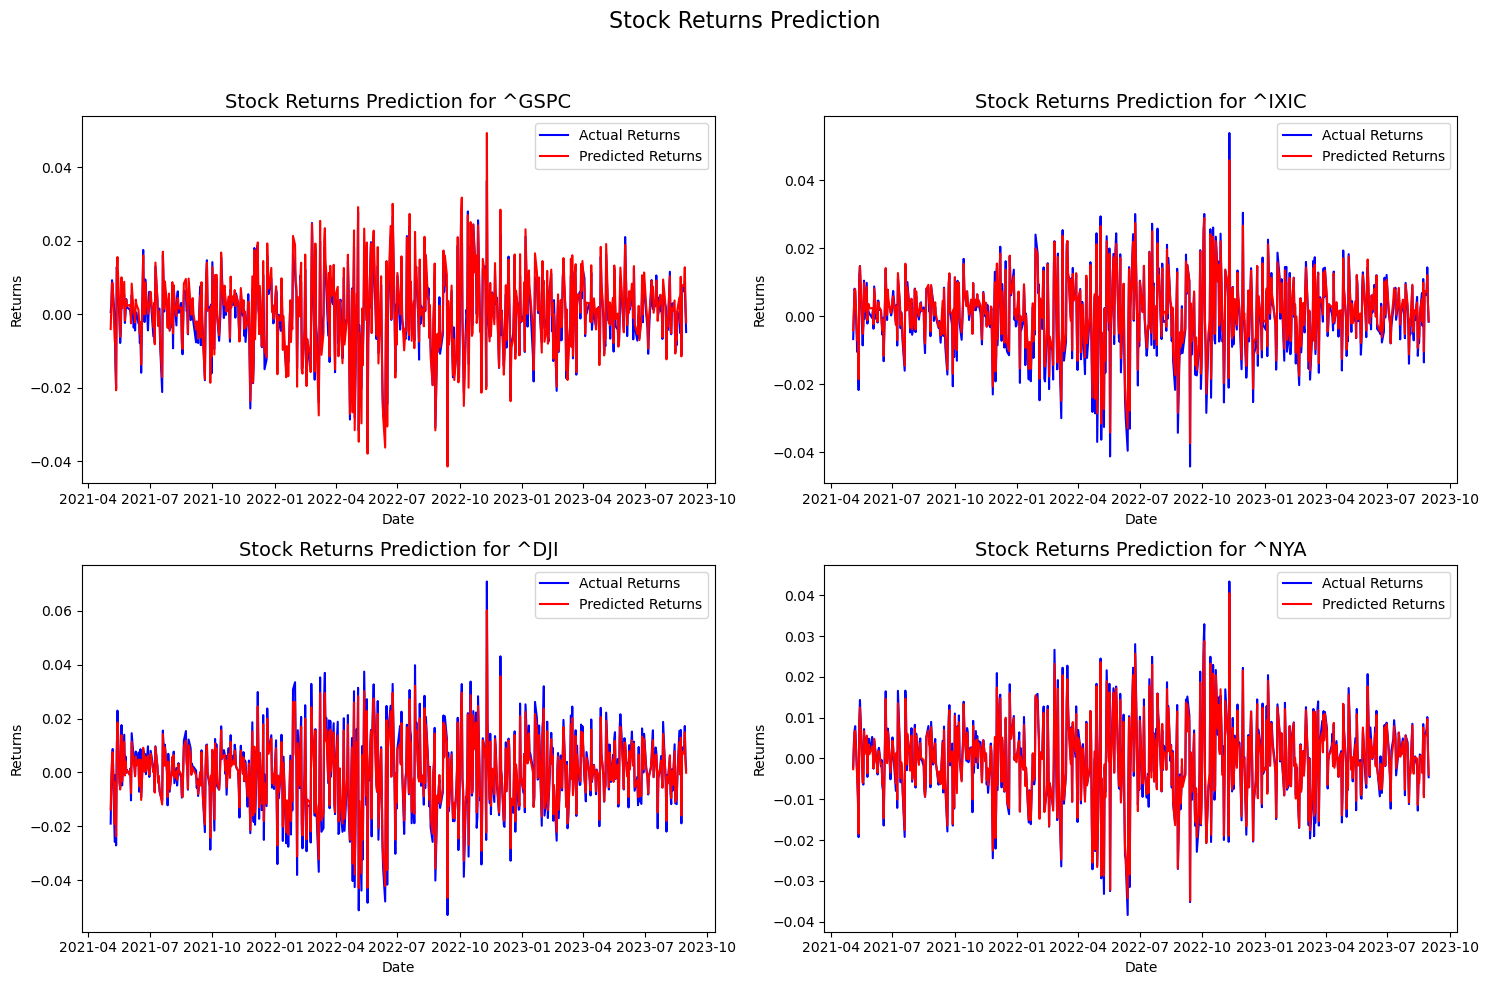

In [ ]:
# ...

# Create a single figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stock Returns Prediction', fontsize=16)  # Modify the main title

for i in range(len(instrumentIds)):
    row = i // 2
    col = i % 2

    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Calculate MSE and R^2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    r2_list.append(r2)
    
    # Store predictions in the dictionary
    predictions[instrumentIds[i]] = y_pred

    # Visualize the prediction results
    axes[row, col].plot(y_test.index, y_test.values, label='Actual Returns', color='blue')
    axes[row, col].plot(y_test.index, y_pred, label='Predicted Returns', color='red')
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Returns')
    axes[row, col].set_title(f'Stock Returns Prediction for {instrumentIds[i]}', fontsize=14)  # Modify subplot title
    axes[row, col].legend()

# Adjust layout for subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a DataFrame with results
results_df = pd.DataFrame({'Stock': stocks, 'MSE': mse_list, 'R^2': r2_list})

# Print the DataFrame with results
print(results_df)

# Print predictions in DataFrame format
predictions_df = pd.DataFrame(predictions, index=y_test.index)
print(predictions_df)

# Show the combined plot
plt.show()


    Stock       MSE       R^2
0   ^GSPC  0.000009  0.913274
1   ^IXIC  0.000005  0.966130
2    ^DJI  0.000008  0.968337
3    ^NYA  0.000002  0.984142
4   ^GSPC  0.000009  0.913274
5   ^IXIC  0.000005  0.966130
6    ^DJI  0.000008  0.968337
7    ^NYA  0.000002  0.984142
8   ^GSPC  0.000009  0.913274
9   ^IXIC  0.000005  0.966130
10   ^DJI  0.000008  0.968337
11   ^NYA  0.000002  0.984142
12  ^GSPC  0.000009  0.913274
13  ^IXIC  0.000005  0.966130
14   ^DJI  0.000008  0.968337
15   ^NYA  0.000002  0.984142
               ^GSPC     ^IXIC      ^DJI      ^NYA
Date                                              
2021-05-04 -0.004035 -0.004139 -0.013838 -0.002640
2021-05-05  0.002468  0.002238 -0.002185  0.002475
2021-05-06  0.008510  0.007701  0.004661  0.006627
2021-05-07  0.008460  0.007975  0.007501  0.006755
2021-05-10 -0.007160 -0.007162 -0.019171 -0.004883
...              ...       ...       ...       ...
2023-08-25  0.007911  0.007481  0.007621  0.005181
2023-08-28  0.007769  0.007357 

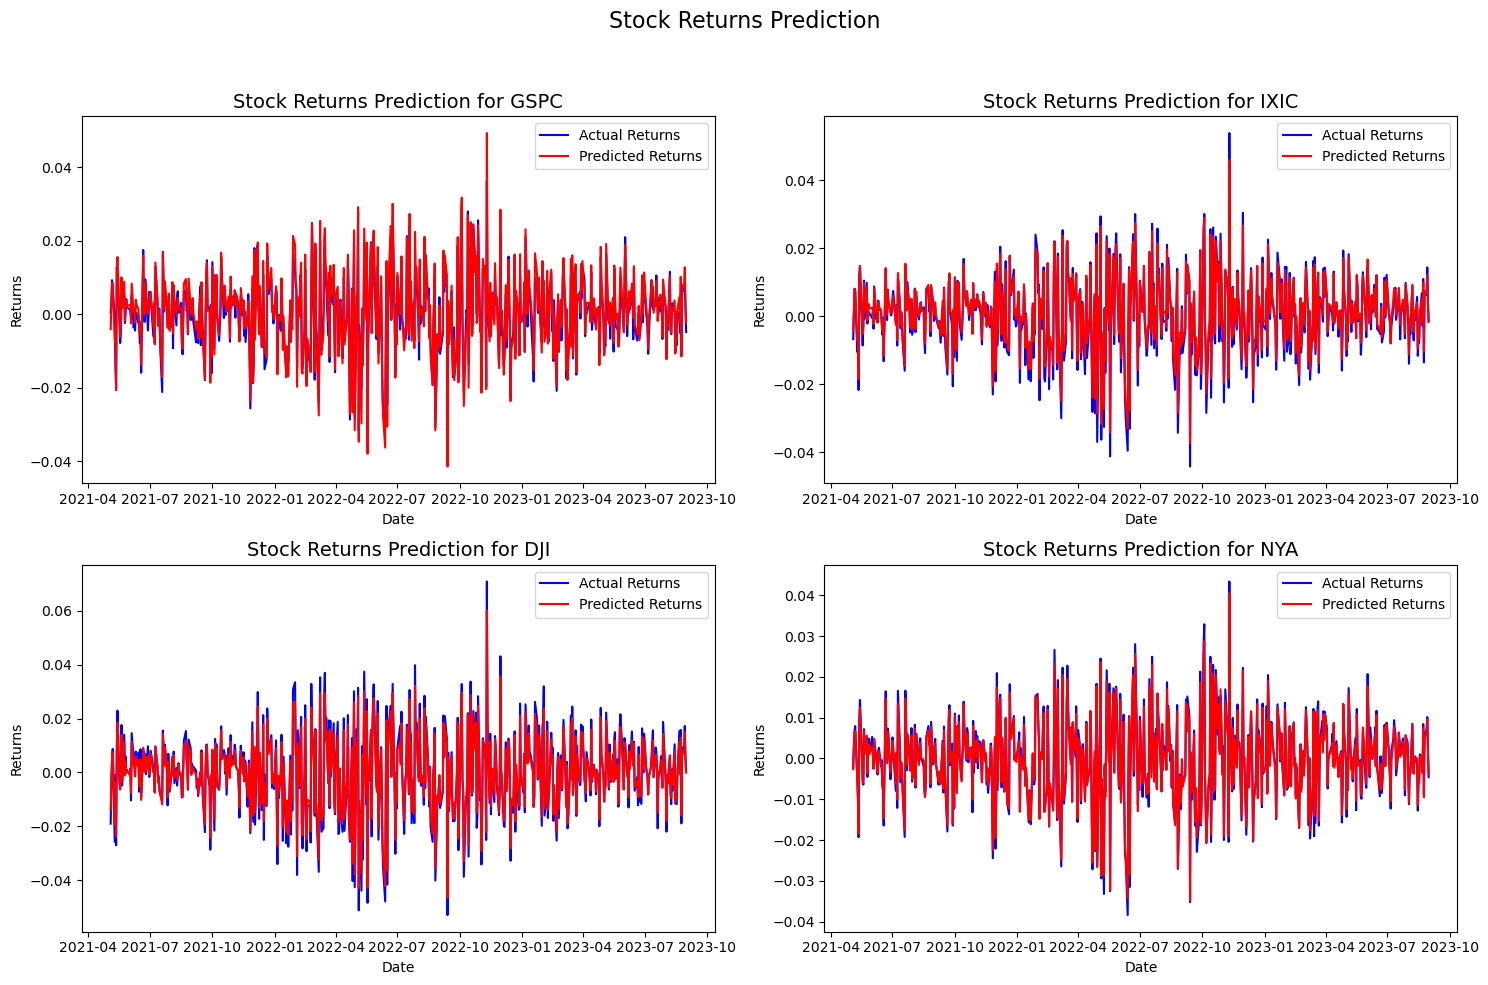

In [ ]:
# ...

# Create a single figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stock Returns Prediction', fontsize=16)  # Modify the main title

for i in range(len(instrumentIds)):
    row = i // 2
    col = i % 2

    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Calculate MSE and R^2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    r2_list.append(r2)
    
    # Store predictions in the dictionary
    predictions[instrumentIds[i]] = y_pred

    # Modify stock name to remove '^'
    stock_name = instrumentIds[i].replace("^", "")

    # Visualize the prediction results
    axes[row, col].plot(y_test.index, y_test.values, label='Actual Returns', color='blue')
    axes[row, col].plot(y_test.index, y_pred, label='Predicted Returns', color='red')
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Returns')
    axes[row, col].set_title(f'Stock Returns Prediction for {stock_name}', fontsize=14)  # Modify subplot title
    axes[row, col].legend()

# Adjust layout for subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a DataFrame with results
results_df = pd.DataFrame({'Stock': stocks, 'MSE': mse_list, 'R^2': r2_list})

# Print the DataFrame with results
print(results_df)

# Print predictions in DataFrame format
predictions_df = pd.DataFrame(predictions, index=y_test.index)
print(predictions_df)

# Show the combined plot
plt.show()


In [14]:
predictions_df=predictions_df.transpose()
predictions_df.to_excel('svr pre 2.xlsx')

    Stock       MSE       R^2
0   ^GSPC  0.000009  0.913274
1   ^IXIC  0.000005  0.966130
2    ^DJI  0.000008  0.968337
3    ^NYA  0.000002  0.984142
4   ^GSPC  0.000009  0.913274
5   ^IXIC  0.000005  0.966130
6    ^DJI  0.000008  0.968337
7    ^NYA  0.000002  0.984142
8   ^GSPC  0.000009  0.913274
9   ^IXIC  0.000005  0.966130
10   ^DJI  0.000008  0.968337
11   ^NYA  0.000002  0.984142
12  ^GSPC  0.000009  0.913274
13  ^IXIC  0.000005  0.966130
14   ^DJI  0.000008  0.968337
15   ^NYA  0.000002  0.984142
16  ^GSPC  0.000009  0.913274
17  ^IXIC  0.000005  0.966130
18   ^DJI  0.000008  0.968337
19   ^NYA  0.000002  0.984142
               ^GSPC     ^IXIC      ^DJI      ^NYA
Date                                              
2021-05-04 -0.004035 -0.004139 -0.013838 -0.002640
2021-05-05  0.002468  0.002238 -0.002185  0.002475
2021-05-06  0.008510  0.007701  0.004661  0.006627
2021-05-07  0.008460  0.007975  0.007501  0.006755
2021-05-10 -0.007160 -0.007162 -0.019171 -0.004883
...          

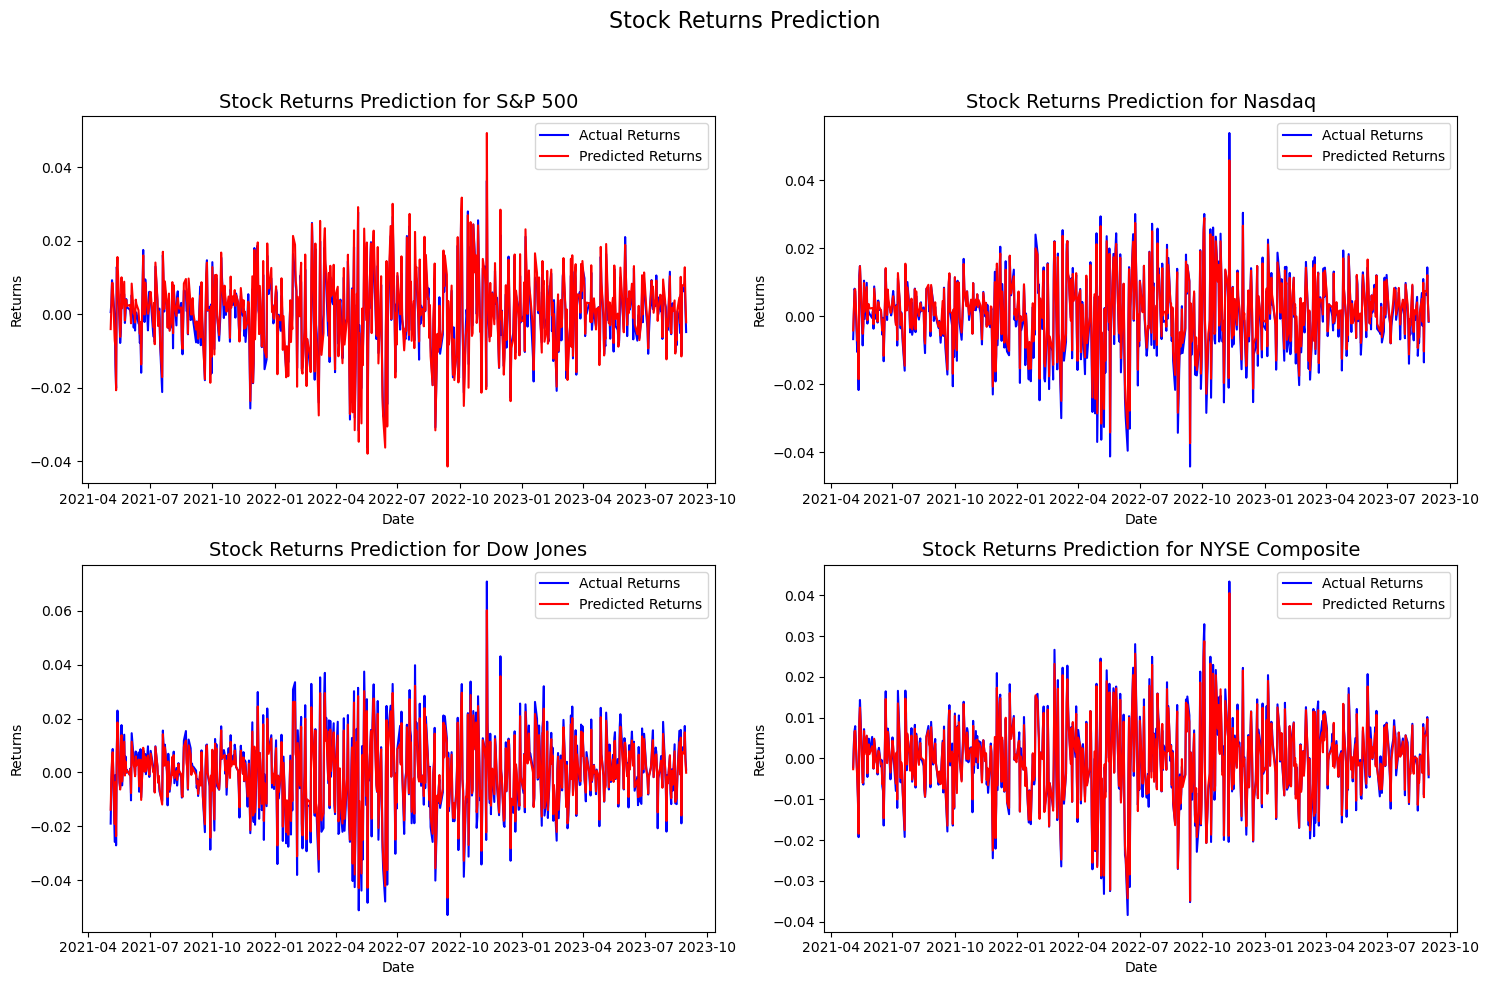

In [ ]:
# 创建股票代码到名称的映射字典
stock_names = {
    "^GSPC": "S&P 500",
    "^IXIC": "Nasdaq",
    "^DJI": "Dow Jones",
    "^NYA": "NYSE Composite"
}

# ...

# Create a single figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stock Returns Prediction', fontsize=16)  # Modify the main title

for i in range(len(instrumentIds)):
    row = i // 2
    col = i % 2

    y_train = return_df.iloc[:train_size, i]  # Assume predicting the i-th stock's return
    y_test = return_df.iloc[train_size:, i]

    # Hyperparameter tuning using Grid Search
    param_grid = {'C': [0.1, 1, 10],
                  'epsilon': [0.01, 0.1, 1],
                  'kernel': ['linear', 'rbf']}
    svr = SVR()
    tscv = TimeSeriesSplit(n_splits=5)  # Time Series cross-validator
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_svr = grid_search.best_estimator_

    # Model prediction
    y_pred = best_svr.predict(X_test)

    # Calculate MSE and R^2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the lists
    stocks.append(instrumentIds[i])
    mse_list.append(mse)
    r2_list.append(r2)
    
    # Modify stock code to stock name
    stock_name = stock_names.get(instrumentIds[i], instrumentIds[i])

    # Visualize the prediction results
    axes[row, col].plot(y_test.index, y_test.values, label='Actual Returns', color='blue')
    axes[row, col].plot(y_test.index, y_pred, label='Predicted Returns', color='red')
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Returns')
    axes[row, col].set_title(f'Stock Returns Prediction for {stock_name}', fontsize=14)  # Modify subplot title
    axes[row, col].legend()

# Adjust layout for subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a DataFrame with results
results_df = pd.DataFrame({'Stock': stocks, 'MSE': mse_list, 'R^2': r2_list})

# Print the DataFrame with results
print(results_df)

# Print predictions in DataFrame format
predictions_df = pd.DataFrame(predictions, index=y_test.index)
print(predictions_df)

# Show the combined plot
plt.show()


In [ ]:
import pandas as pd

# 创建包含每个指数的数据字典
data = {
    '^GSPC': {
        'Model': 'SVM Model Parameters',
        'Parameters': 'SVR(C=0.1, epsilon=0.01, kernel=\'linear\')'
    },
    '^IXIC': {
        'Model': 'SVM Model Parameters',
        'Parameters': 'SVR(C=0.1, epsilon=0.01, kernel=\'linear\')'
    },
    '^DJI': {
        'Model': 'SVM Model Parameters',
        'Parameters': 'SVR(C=0.1, epsilon=0.01, kernel=\'linear\')'
    },
    '^NYA': {
        'Model': 'SVM Model Parameters',
        'Parameters': 'SVR(C=0.1, epsilon=0.01, kernel=\'linear\')'
    }
}

# 创建多层级DataFrame
df = pd.DataFrame(data).T
df.index.name = 'Index'

# 显示多层级表格
print(df)


                      Model                                 Parameters
Index                                                                 
^GSPC  SVM Model Parameters  SVR(C=0.1, epsilon=0.01, kernel='linear')
^IXIC  SVM Model Parameters  SVR(C=0.1, epsilon=0.01, kernel='linear')
^DJI   SVM Model Parameters  SVR(C=0.1, epsilon=0.01, kernel='linear')
^NYA   SVM Model Parameters  SVR(C=0.1, epsilon=0.01, kernel='linear')


In [ ]:
df

,Model,Parameters
Index,,
^GSPC,SVM Model Parameters,"SVR(C=0.1, epsilon=0.01, kernel='linear')"
^IXIC,SVM Model Parameters,"SVR(C=0.1, epsilon=0.01, kernel='linear')"
^DJI,SVM Model Parameters,"SVR(C=0.1, epsilon=0.01, kernel='linear')"
^NYA,SVM Model Parameters,"SVR(C=0.1, epsilon=0.01, kernel='linear')"
